In [1]:
#coding=utf-8
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Latex
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import geatpy as ea
import time
import numpy as np
import pandas as pd
import math as m
import os

from docplex.mp.model import Model
from itertools import product

import matplotlib.pyplot as plt

# 4. A meeting model for a drone and directional mobile ship [M2]

In [3]:
def solve_M2(Xk,Yk,Vk,xi,xt,yi,yt,vi,meet=False):
    if meet==False:
        t = np.sqrt((Xk-xi)**2 + (Yk-xi)**2)/Vk
        return {'t':t,'x':xi,'y':yi}
    
    vix = vi*(xt-xi)/np.sqrt((xi-xt)**2+(yi-yt)**2)
    viy = vi*(yt-yi)/np.sqrt((xi-xt)**2+(yi-yt)**2)
    a = vix**2 + viy**2 - Vk**2
    b = 2*(vix*(xi-Xk) + viy*(yi-Yk))
    c = (xi-Xk)**2 + (yi-Yk)**2
    t1 = (-b-np.sqrt(b**2-4*a*c))/(2*a)
    t2 = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    t = max(t1,t2)
    x,y = xi+vix*t,yi+viy*t
    return {'t':t,'x':x,'y':y}

## 6.2. Dataset generation

In [4]:
def data(K=1,N=10,Vk=25,X=20,Y=10,seed=10):
    Vk = (Vk/1000)/(1/3600)
    fn = '../data/K{}N{}V{}X{}Y{}.xlsx'.format(K,N,Vk,X, Y)    
    dK = {1:{'Xk':0,'Yk':0,'Vk':Vk,'Qk':N},}
    if K>1:
        Xk = np.linspace(float(0), float(X), K)
        Qk = np.ceil(N/K)
        dK = {(k+1):{'Xk':x,'Yk':0,'Vk':Vk,'Qk':Qk} for k,x in enumerate(Xk)}
        
    if os.path.exists(fn):
        df = pd.read_excel(fn)
        return df, dK
    
    np.random.seed(seed)
    Xi = np.random.randint(low=0,high=X,size=N)
    Xt = np.random.randint(low=0,high=X,size=N)
    Yi = np.random.randint(low=int(0.7*Y),high=Y,size=N)
    Yt = np.random.randint(low=int(0.4*Y),high=int(0.7*Y),size=N)
    Vi = np.random.randint(low=5, high=10,size=N)
    Vi = (Vi/1000)/(1/3600)
    data = {'Xi':Xi,'Xt':Xt,'Yi':Yi,'Yt':Yt,'Vi':Vi}
    df = pd.DataFrame(data)
    df.to_excel(fn,index=None)
    return df, dK

def prepare_data(df,dK,meet=False):
    df['i'] = list(range(1,len(df)+1))
    df = df.set_index('i')
    I = df.index.tolist()
    Xi,Xt = dict(df['Xi']),dict(df['Xt'])
    Yi,Yt = dict(df['Yi']),dict(df['Yt'])
    Vi = dict(df['Vi'])
    Cki = {(k,i):solve_M2(dK[k]['Xk'],dK[k]['Yk'],dK[k]['Vk'],Xi[i],Xt[i],Yi[i],Yt[i],Vi[i],meet=meet)
           for k in dK.keys() for i in I}
    Qk = {k:dK[k]['Qk'] for k in dK}
    return I,Xi,Xt,Yi,Yt,Vi,Cki,Qk

In [5]:
df, dK = data(K=3,N=10,Vk=25,X=20, Y=10,seed=10)
df
dK
I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=False)
I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=True)

,Xi,Xt,Yi,Yt,Vi
0,9,10,7,5,28.8
1,4,8,7,4,25.2
2,15,4,9,6,18.0
3,0,19,8,6,28.8
4,17,16,9,6,32.4
5,16,4,8,5,25.2
6,17,15,8,4,18.0
7,8,11,8,5,21.6
8,9,11,8,5,25.2
9,0,1,9,4,18.0


{1: {'Xk': 0.0, 'Yk': 0, 'Vk': 90.0, 'Qk': 4.0},
 2: {'Xk': 10.0, 'Yk': 0, 'Vk': 90.0, 'Qk': 4.0},
 3: {'Xk': 20.0, 'Yk': 0, 'Vk': 90.0, 'Qk': 4.0}}

In [13]:
def test():
    Xk,Yk,Vk = 0,0,25
    Xi,Xt,Yi,Yt,Vi = df['Xi'],df['Xt'],df['Yi'],df['Yt'],df['Vi']
    Vix = Vi*(Xt-Xi)/np.sqrt((Xi-Xt)**2+(Yi-Yt)**2)
    Viy = Vi*(Yt-Yi)/np.sqrt((Xi-Xt)**2+(Yi-Yt)**2)
    T = np.linspace(float(0), float(5), 10*60)
    for xi,xt,yi,yt,vix,viy,vi in zip(Xi,Xt,Yi,Yt,Vix,Viy,Vi):
        s = ((xi+T*vix-Xk)**2 + (yi+T*viy-Yk)**2 - (T*Vk)**2)**2
        txy = solve_M2(Xk,Yk,Vk,xi,xt,yi,yt,vi)
        t,x,y = txy['t'],txy['x'],txy['y']
        print(np.round(s.min(),3),np.round(np.abs(T[s.argmin()]-t),3),np.round(t,3),np.round(x,3),np.round(y,3))

# 3. Scheduling drones for immobile ships [M1]

In [8]:
def M1(dK,I,Cki,Qk):
    m = Model("VRP")
    #  define decision variables
    x = m.binary_var_dict(Cki)
    # objective function
    m.minimize(m.sum(Cki[k,i]['t']*x[k,i] for k,i in Cki))
    m.add_constraints(m.sum(x[k,i] for k in dK) == 1 for i in I)
    m.add_constraints(m.sum(x[k,i] for i in I) <= Qk[k] for k in dK)
    m.x = x
    return m

def solve_M1(K,I,Cki,Qk):
    m = M1(K,I,Cki,Qk)
    # m.parameters.timelimit = 1000
    s = m.solve(log_output=False)
    if not s:
        return
    xv = [(k,i) for k,i in Cki if m.x[k,i].solution_value > 0.001]
    #draw(xv)
    return xv,m.objective_value


def draw(dK,I,Xi,Xt,Yi,Yt,Cki,xv,meet=False,fn='1.svg'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for k,i in xv:
        plt.plot((Xi[i],Cki[k,i]['x']), (Yi[i],Cki[k,i]['y']), color='black')
        if meet:
            ax.arrow(Xi[i],Yi[i],Cki[k,i]['x']-Xi[i],Cki[k,i]['y']-Yi[i],
                    length_includes_head = True,
                    head_width = 0.25,head_length = 0.5,fc='black',ec='black')
            ax.arrow(Cki[k,i]['x'],Cki[k,i]['y'],
                     Xt[i]-Cki[k,i]['x'],Yt[i]-Cki[k,i]['y'],
                     length_includes_head = True,
                     head_width = 0.25,head_length = 0.5,fc='grey',ec='grey',
                    linestyle=':')
            
        else:
            ax.arrow(Xi[i],Yi[i],Xt[i]-Xi[i],Yt[i]-Yi[i],
                    length_includes_head = True,
                    head_width = 0.25,head_length = 0.5,fc='black',ec='black')
            
    for k,i in xv:
        plt.plot((dK[k]['Xk'],Cki[k,i]['x']), (dK[k]['Yk'],Cki[k,i]['y']), color='grey')
        ax.arrow(dK[k]['Xk'],dK[k]['Yk'],Cki[k,i]['x']-dK[k]['Xk'],Cki[k,i]['y']-dK[k]['Yk'],
                length_includes_head = True,
                head_width = 0.25,head_length = 0.5,fc='black',ec='grey')
    plt.savefig(fn)
    plt.show()


### 6.3.1. Demonstration of [M1] and [M3]

(2.5243865118077764, 56.8864207525322, 0.8563215818895288, 77.0689423700576)

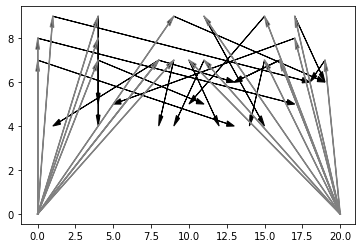

(1.9913291387523389, 46.227487788858184)

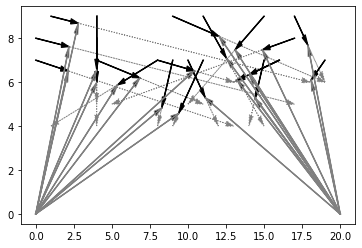

In [9]:
K,N,Vk,X,Y,seed = 2,20,25,20,10,10
df, dK = data(K=K,N=N,Vk=Vk,X=X,Y=Y,seed=seed)

I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=False)
xv,obj = solve_M1(dK,I,Cki,Qk)
d = [Cki[k,i]['t']*Vi[i] for (k,i) in xv]
tchase = [Cki[k,i]['t']*Vi[i]/(dK[k]['Vk']-Vi[i]) for (k,i) in xv]
lchase = [dK[k]['Vk']*Cki[k,i]['t']*Vi[i]/(dK[k]['Vk']-Vi[i]) for (k,i) in xv]

obj,np.sum(d),np.sum(tchase),np.sum(lchase)
fn_svg = fn='K{}.N{}.X{}.Y{}.{}.svg'.format(K,N,X,Y,'False')
draw(dK,I,Xi,Xt,Yi,Yt,Cki,xv,meet=False,fn=fn_svg)

I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=True)
xv,obj = solve_M1(dK,I,Cki,Qk)
d = [Cki[k,i]['t']*Vi[i] for (k,i) in xv]

obj,np.sum(d)
fn_svg = fn='K{}.N{}.X{}.Y{}.{}.svg'.format(K,N,X,Y,'True')
draw(dK,I,Xi,Xt,Yi,Yt,Cki,xv,meet=True,fn=fn_svg)

### 6.3.2. Comparing [M1] and [M3]

In [10]:
ret = []
vK,vN = [2,3],[10,15,20,25,30,35,40,45,50]
Vk,X,Y,seed = 25,20,20,10
for K,N in product(vK,vN):
    df, dK = data(K=K,N=N,Vk=Vk,X=X,Y=Y,seed=seed)
    I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=False)
    xv,t_M1 = solve_M1(dK,I,Cki,Qk)
    l_M1 = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    tchase = np.sum([Cki[k,i]['t']*Vi[i]/(dK[k]['Vk']-Vi[i]) for (k,i) in xv])
    lchase = np.sum([dK[k]['Vk']*Cki[k,i]['t']*Vi[i]/(dK[k]['Vk']-Vi[i]) for (k,i) in xv])

    I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=True)
    xv,t_M3 = solve_M1(dK,I,Cki,Qk)
    l_M3 = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])

    ret.append([K,N,t_M1,l_M1,tchase,lchase,t_M3,l_M3])
    
df_M1M3 = pd.DataFrame(ret,columns=['K','N','t_M1','l_M1','tchase','lchase','t_M3','l_M3'])
df_M1M3['t_M1.tchase'] = df_M1M3['t_M1'] + df_M1M3['tchase']
df_M1M3['l_M1.lchase'] = df_M1M3['l_M1'] + df_M1M3['lchase']

df_M1M3['tpercent'] = (df_M1M3['t_M1.tchase']-df_M1M3['t_M3'])*100/df_M1M3['t_M1.tchase']
df_M1M3['lpercent'] = (df_M1M3['l_M1.lchase']-df_M1M3['l_M3'])*100/df_M1M3['l_M1.lchase']

df_M1M3.to_excel('../data/o.df_M1M3.xlsx',index=None)
df_M1M3

,K,N,t_M1,l_M1,tchase,lchase,t_M3,l_M3,t_M1.tchase,l_M1.lchase,tpercent,lpercent
0,2,10,1.230448,27.397419,0.415073,37.356596,1.763451,41.115635,1.645521,64.754015,-7.166723,36.504887
1,2,15,1.954300,45.688508,0.708784,63.790519,2.597939,62.933106,2.663083,109.479027,2.446218,42.515834
2,2,20,2.524387,59.838981,0.916546,82.489111,3.251290,74.651284,3.440932,142.328092,5.511373,47.549860
3,2,25,3.285399,80.866639,1.263144,113.682951,4.212259,102.845440,4.548542,194.549590,7.393224,47.136645
4,2,30,4.082460,99.411876,1.545639,139.107513,4.935491,121.575764,5.628099,238.519390,12.306248,49.028981
5,2,35,4.686558,117.019737,1.839124,165.521172,5.780970,145.074926,6.525682,282.540909,11.412021,48.653479
6,2,40,5.534876,140.280637,2.216600,199.494021,6.628138,165.621332,7.751476,339.774659,14.491925,51.255537
7,2,45,6.362014,159.375822,2.517764,226.598754,7.528333,186.567233,8.879778,385.974577,15.219363,51.663336
8,2,50,6.805888,174.552591,2.779076,250.116873,8.437707,213.936845,9.584964,424.669464,11.969341,49.622739
9,3,10,1.098256,25.017956,0.382025,34.382266,1.647665,38.606205,1.480281,59.400222,-11.307625,35.006632


### 6.3.3. Sensitivity analysis of speeds by solving [M3]

#### 6.3.3.1. Sensitivity of ships' speeds

In [11]:
ret = []
vK,vN = [2,3],[10,15,20,25,30,35,40,45,50]
Vk,X,Y,seed = 25,20,20,10

for K,N in product(vK,vN):
    df, dK = data(K=K,N=N,Vk=Vk,X=X,Y=Y,seed=seed)
    I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=True)
    
    Vi = df['Vi']
    Vi_sub = Vi*(1-0.05)
    df1 = df.copy()
    df1['Vi'] = Vi_sub
    I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df1,dK,meet=True)
    xv,t_M3_sub = solve_M1(dK,I,Cki,Qk)
    l_M3_sub = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    xv,t_M3_sub = solve_M1(dK,I,Cki,Qk)
    l_M3_sub = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])

    I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=True)
    xv,t_M3 = solve_M1(dK,I,Cki,Qk)
    l_M3 = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    xv,t_M3 = solve_M1(dK,I,Cki,Qk)
    l_M3 = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    
    Vi = df['Vi']
    Vi_add = Vi*(1+0.05)
    df2 = df.copy()
    df2['Vi'] = Vi_add
    I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df2,dK,meet=True)
    xv,t_M3_add = solve_M1(dK,I,Cki,Qk)
    l_M3_add = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    xv,t_M3_add = solve_M1(dK,I,Cki,Qk)
    l_M3_add = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    
    ret.append([K,N,t_M3_sub,t_M3,t_M3_add,l_M3_sub,l_M3,l_M3_add])
    
df_Vi = pd.DataFrame(ret,columns=['K','N','t_M3_sub','t_M3','t_M3_add','l_M3_sub','l_M3','l_M3_add'])
df_Vi['t_M3_sub.r'] = (df_Vi['t_M3']-df_Vi['t_M3_sub'])*100/df_Vi['t_M3']
df_Vi['t_M3_add.r'] = (df_Vi['t_M3']-df_Vi['t_M3_add'])*100/df_Vi['t_M3']
df_Vi['l_M3_sub.r'] = (df_Vi['l_M3']-df_Vi['l_M3_sub'])*100/df_Vi['l_M3']
df_Vi['l_M3_add.r'] = (df_Vi['l_M3']-df_Vi['l_M3_add'])*100/df_Vi['l_M3']

df_Vi.to_excel('../data/o.df_Vi.xlsx',index=None)
df_Vi

,K,N,t_M3_sub,t_M3,t_M3_add,l_M3_sub,l_M3,l_M3_add,t_M3_sub.r,t_M3_add.r,l_M3_sub.r,l_M3_add.r
0,2,10,1.776295,1.763451,1.750932,39.356583,41.115635,42.851997,-0.728308,0.709904,4.278304,-4.223117
1,2,15,2.609052,2.597939,2.586011,60.057263,62.933106,65.932320,-0.427761,0.459134,4.569683,-4.765717
2,2,20,3.271808,3.251290,3.231363,71.391062,74.651284,77.876911,-0.631098,0.612883,4.367268,-4.320927
3,2,25,4.238409,4.212259,4.186957,98.310457,102.845440,107.339919,-0.620815,0.600656,4.409513,-4.370130
4,2,30,4.972851,4.935491,4.899118,116.390592,121.575764,126.693847,-0.756971,0.736973,4.264972,-4.209788
5,2,35,5.815772,5.780970,5.747369,138.674585,145.074926,151.419204,-0.602014,0.581247,4.411749,-4.373104
6,2,40,6.665994,6.628138,6.591672,158.270852,165.621332,172.913127,-0.571147,0.550161,4.438124,-4.402690
7,2,45,7.577456,7.528333,7.480779,178.457948,186.567233,194.592153,-0.652513,0.631656,4.346575,-4.301356
8,2,50,8.498005,8.437707,8.379206,204.731502,213.936845,223.036661,-0.714627,0.693329,4.302832,-4.253506
9,3,10,1.658667,1.647665,1.636963,36.923710,38.606205,40.270481,-0.667743,0.649552,4.358095,-4.310904


#### 6.3.3.2. Sensitivity of drones' speeds

In [12]:
ret = []
vK,vN = [2,3],[10,15,20,25,30,35,40,45,50]
Vk,X,Y,seed = 25,20,20,10

for K,N in product(vK,vN):
    v = []
    Vk1 = Vk*(1-0.05)
    df, dK = data(K=K,N=N,Vk=Vk1,X=X,Y=Y,seed=seed)
    I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=True)
    xv,t_M3_sub = solve_M1(dK,I,Cki,Qk)
    l_M3_sub = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    xv,t_M3_sub = solve_M1(dK,I,Cki,Qk)
    l_M3_sub = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])

    Vk2 = Vk
    df, dK = data(K=K,N=N,Vk=Vk2,X=X,Y=Y,seed=seed)
    I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=True)
    xv,t_M3 = solve_M1(dK,I,Cki,Qk)
    l_M3 = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    xv,t_M3 = solve_M1(dK,I,Cki,Qk)
    l_M3 = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    
    Vk3 = Vk*(1+0.05)
    df, dK = data(K=K,N=N,Vk=Vk3,X=X,Y=Y,seed=seed)
    I,Xi,Xt,Yi,Yt,Vi,Cki,Qk = prepare_data(df,dK,meet=True)
    xv,t_M3_add = solve_M1(dK,I,Cki,Qk)
    l_M3_add = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    xv,t_M3_add = solve_M1(dK,I,Cki,Qk)
    l_M3_add = np.sum([Cki[k,i]['t']*Vi[i] for (k,i) in xv])
    
    ret.append([K,N,t_M3_sub,t_M3,t_M3_add,l_M3_sub,l_M3,l_M3_add])
    
df_Vk = pd.DataFrame(ret,columns=['K','N','t_M3_sub','t_M3','t_M3_add','l_M3_sub','l_M3','l_M3_add'])
df_Vk['t_M3_sub.r'] = (df_Vk['t_M3']-df_Vk['t_M3_sub'])*100/df_Vk['t_M3']
df_Vk['t_M3_add.r'] = (df_Vk['t_M3']-df_Vk['t_M3_add'])*100/df_Vk['t_M3']
df_Vk['l_M3_sub.r'] = (df_Vk['l_M3']-df_Vk['l_M3_sub'])*100/df_Vk['l_M3']
df_Vk['l_M3_add.r'] = (df_Vk['l_M3']-df_Vk['l_M3_add'])*100/df_Vk['l_M3']

df_Vk.to_excel('../data/o.df_Vk.xlsx',index=None)
df_Vk

,K,N,t_M3_sub,t_M3,t_M3_add,l_M3_sub,l_M3,l_M3_add,t_M3_sub.r,t_M3_add.r,l_M3_sub.r,l_M3_add.r
0,2,10,1.842402,1.763451,1.691120,42.942774,41.115635,39.440877,-4.477088,4.101712,-4.443903,4.073288
1,2,15,2.721273,2.597939,2.484295,66.075430,62.933106,60.194536,-4.747402,4.374367,-4.993117,4.351558
2,2,20,3.400348,3.251290,3.115064,78.045758,74.651284,71.547123,-4.584587,4.189879,-4.547108,4.158215
3,2,25,4.405946,4.212259,4.035375,107.575406,102.845440,98.527371,-4.598193,4.199247,-4.599101,4.198600
4,2,30,5.154979,4.935491,4.734333,126.961421,121.575764,116.639074,-4.447141,4.075749,-4.429877,4.060588
5,2,35,6.048035,5.780970,5.537226,151.751642,145.074926,138.980698,-4.619716,4.216314,-4.602253,4.200746
6,2,40,6.936623,6.628138,6.346819,173.295376,165.621332,158.622281,-4.654168,4.244315,-4.633488,4.225936
7,2,45,7.871915,7.528333,7.214363,195.012283,186.567233,178.846098,-4.563862,4.170513,-4.526545,4.138527
8,2,50,8.817027,8.437707,8.090564,223.512794,213.936845,205.172338,-4.495538,4.114184,-4.476063,4.096773
9,3,10,1.722534,1.647665,1.579178,40.357588,38.606205,37.004256,-4.543955,4.156641,-4.536534,4.149460
